Median Age: 74.25


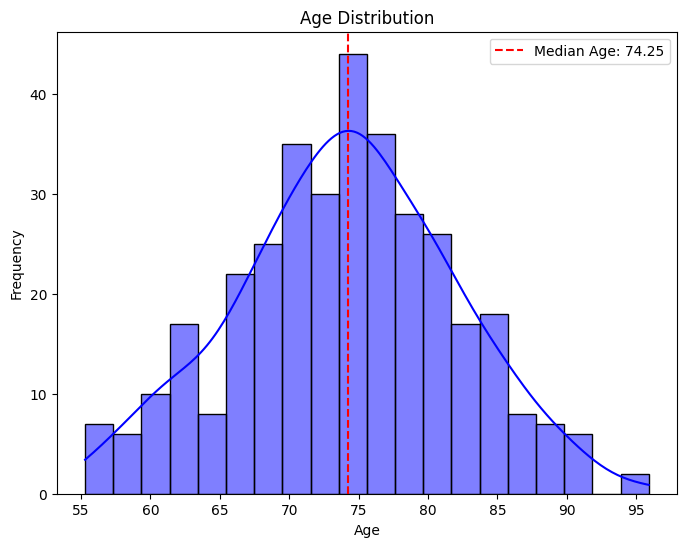

/tmp/ipykernel_590213/3646991604.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sex', data=subjects_df, palette='coolwarm')


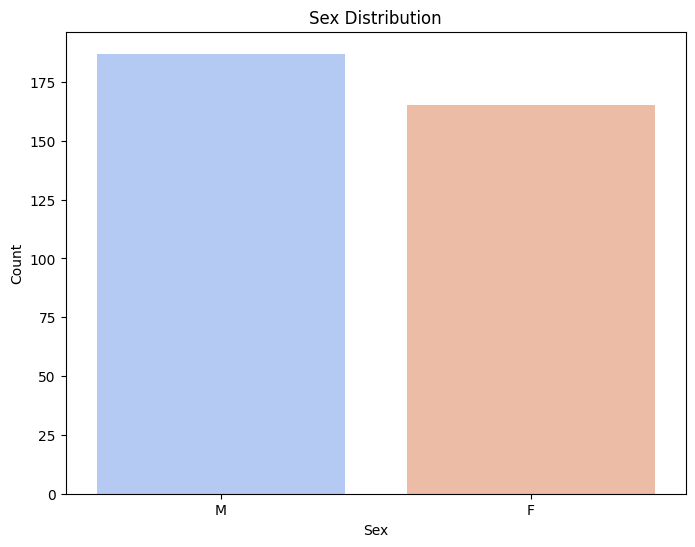

/tmp/ipykernel_590213/3646991604.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='ResearchGroup', data=subjects_df, palette='viridis')


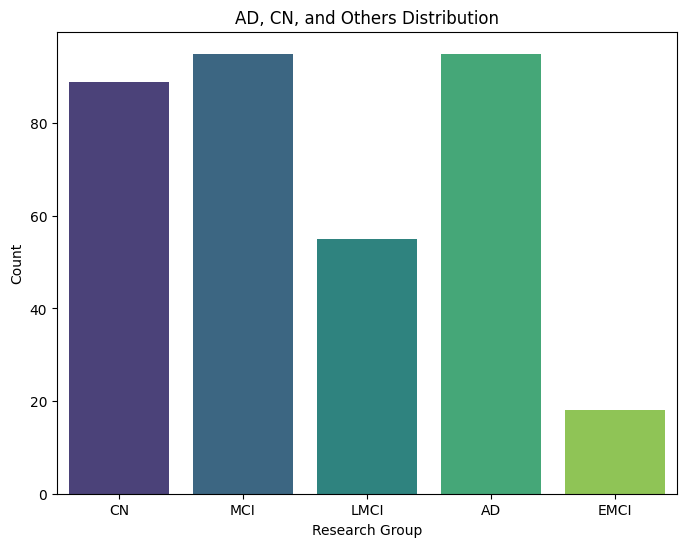

Sex             F   M
ResearchGroup        
AD             40  55
CN             52  37
EMCI            8  10
LMCI           23  32
MCI            42  53
AD_men: 55 subjects
AD_women: 40 subjects
CN_men: 37 subjects
CN_women: 52 subjects
Other_men: 95 subjects
Other_women: 73 subjects
Train set: 244 subjects
Validation set: 50 subjects
Test set: 58 subjects


In [1]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# Set paths
project_dir = '/home/diego/Escritorio/azheimer/'  # Adjust to your path
csv_path = os.path.join(project_dir, 'DataBaseSubjects.csv')
tensor_data_dir = os.path.join(project_dir, 'TensorData')

# Load the CSV file
subjects_df = pd.read_csv(csv_path)

# Calculate the median age and print it
median_age = subjects_df['Age'].median()
print(f"Median Age: {median_age}")

# Plot the age distribution
plt.figure(figsize=(8, 6))
sns.histplot(subjects_df['Age'], bins=20, kde=True, color='blue')
plt.axvline(median_age, color='red', linestyle='--', label=f'Median Age: {median_age}')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Plot the sex distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Sex', data=subjects_df, palette='coolwarm')
plt.title('Sex Distribution')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.show()

# Plot the distribution of AD, CN, and Others
plt.figure(figsize=(8, 6))
sns.countplot(x='ResearchGroup', data=subjects_df, palette='viridis')
plt.title('AD, CN, and Others Distribution')
plt.xlabel('Research Group')
plt.ylabel('Count')
plt.show()

# Group subjects by Research Group and Sex
grouped_data = subjects_df.groupby(['ResearchGroup', 'Sex']).size().unstack().fillna(0)
print(grouped_data)

# Initialize dictionaries for storing tensor paths by group and sex
tensor_groups = {
    'AD_men': [],
    'AD_women': [],
    'CN_men': [],
    'CN_women': [],
    'Other_men': [],
    'Other_women': []
}

# Iterate over subjects and assign tensors to groups
for subject_id in subjects_df['SubjectID']:
    group = subjects_df[subjects_df['SubjectID'] == subject_id]['ResearchGroup'].values[0]
    sex = subjects_df[subjects_df['SubjectID'] == subject_id]['Sex'].values[0]
    file_name = f'{group}_tensor_{subject_id}.pt'
    file_path = os.path.join(tensor_data_dir, file_name)
    
    if os.path.exists(file_path):
        if group == 'AD':
            if sex == 'M':
                tensor_groups['AD_men'].append(file_path)
            elif sex == 'F':
                tensor_groups['AD_women'].append(file_path)
        elif group == 'CN':
            if sex == 'M':
                tensor_groups['CN_men'].append(file_path)
            elif sex == 'F':
                tensor_groups['CN_women'].append(file_path)
        else:  # Others
            if sex == 'M':
                tensor_groups['Other_men'].append(file_path)
            elif sex == 'F':
                tensor_groups['Other_women'].append(file_path)

# Print the number of subjects in each group
for key, value in tensor_groups.items():
    print(f'{key}: {len(value)} subjects')

# Split data into train, validation, and test sets with equal proportions
def split_data(tensors, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    np.random.shuffle(tensors)
    n_total = len(tensors)
    n_train = int(n_total * train_ratio)
    n_val = int(n_total * val_ratio)
    
    train_set = tensors[:n_train]
    val_set = tensors[n_train:n_train + n_val]
    test_set = tensors[n_train + n_val:]
    
    return train_set, val_set, test_set

# Initialize lists for train, validation, and test sets
train_set, val_set, test_set = [], [], []

# Combine groups ensuring equal proportions of gender and research groups
for group in tensor_groups:
    train, val, test = split_data(tensor_groups[group])
    train_set.extend(train)
    val_set.extend(val)
    test_set.extend(test)

# Print final counts of train, validation, and test sets
print(f"Train set: {len(train_set)} subjects")
print(f"Validation set: {len(val_set)} subjects")
print(f"Test set: {len(test_set)} subjects")




In [2]:
# Function to normalize each channel of the tensor between 0 and 1
def normalize_tensor(tensor):
    normalized_tensor = torch.zeros_like(tensor)
    for i in range(tensor.shape[0]):  # For each channel
        channel_data = tensor[i]
        min_val = channel_data.min()
        max_val = channel_data.max()
        # Avoid division by zero
        if max_val - min_val != 0:
            normalized_tensor[i] = (channel_data - min_val) / (max_val - min_val)
        else:
            normalized_tensor[i] = channel_data - min_val
    return normalized_tensor


In [3]:
# Load the tensors and create datasets
def load_tensors(file_paths):
    tensors = []
    for fp in file_paths:
        data = torch.load(fp)
        if isinstance(data, np.ndarray):  # Convert numpy arrays to tensors
            data = torch.tensor(data)
        # Normalize the data
        data = normalize_tensor(data)
        tensors.append(data)
    return torch.stack(tensors)


# Load data for train, validation, and test sets
train_data = load_tensors(train_set)
val_data = load_tensors(val_set)
test_data = load_tensors(test_set)

# Print final dataset shapes
print(f"Train data shape: {train_data.shape}")
print(f"Validation data shape: {val_data.shape}")
print(f"Test data shape: {test_data.shape}")


Train data shape: torch.Size([244, 3, 116, 116])
Validation data shape: torch.Size([50, 3, 116, 116])
Test data shape: torch.Size([58, 3, 116, 116])


Plotting matrices for a random subject from Train dataset: /home/diego/Escritorio/azheimer/TensorData/CN_tensor_012_S_4026.pt


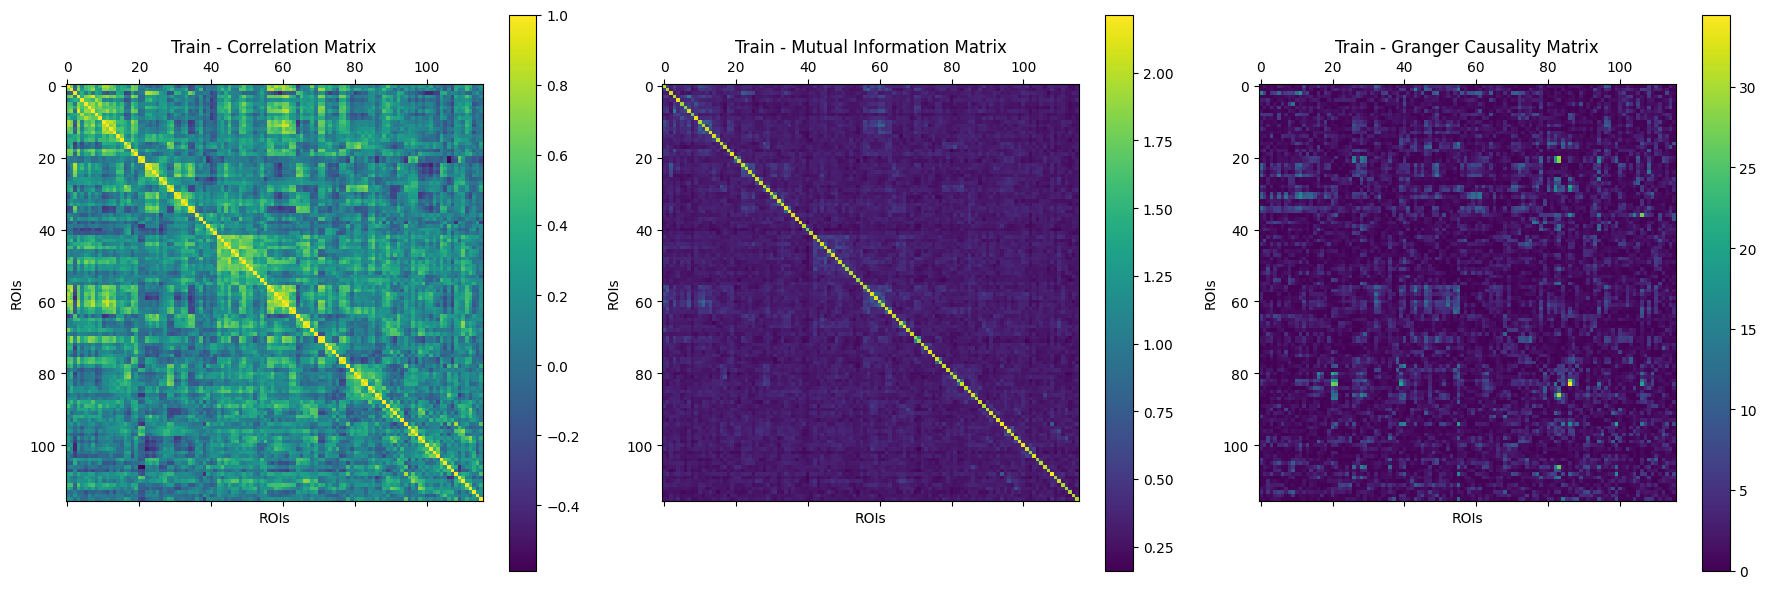

Plotting matrices for a random subject from Validation dataset: /home/diego/Escritorio/azheimer/TensorData/MCI_tensor_018_S_6414.pt


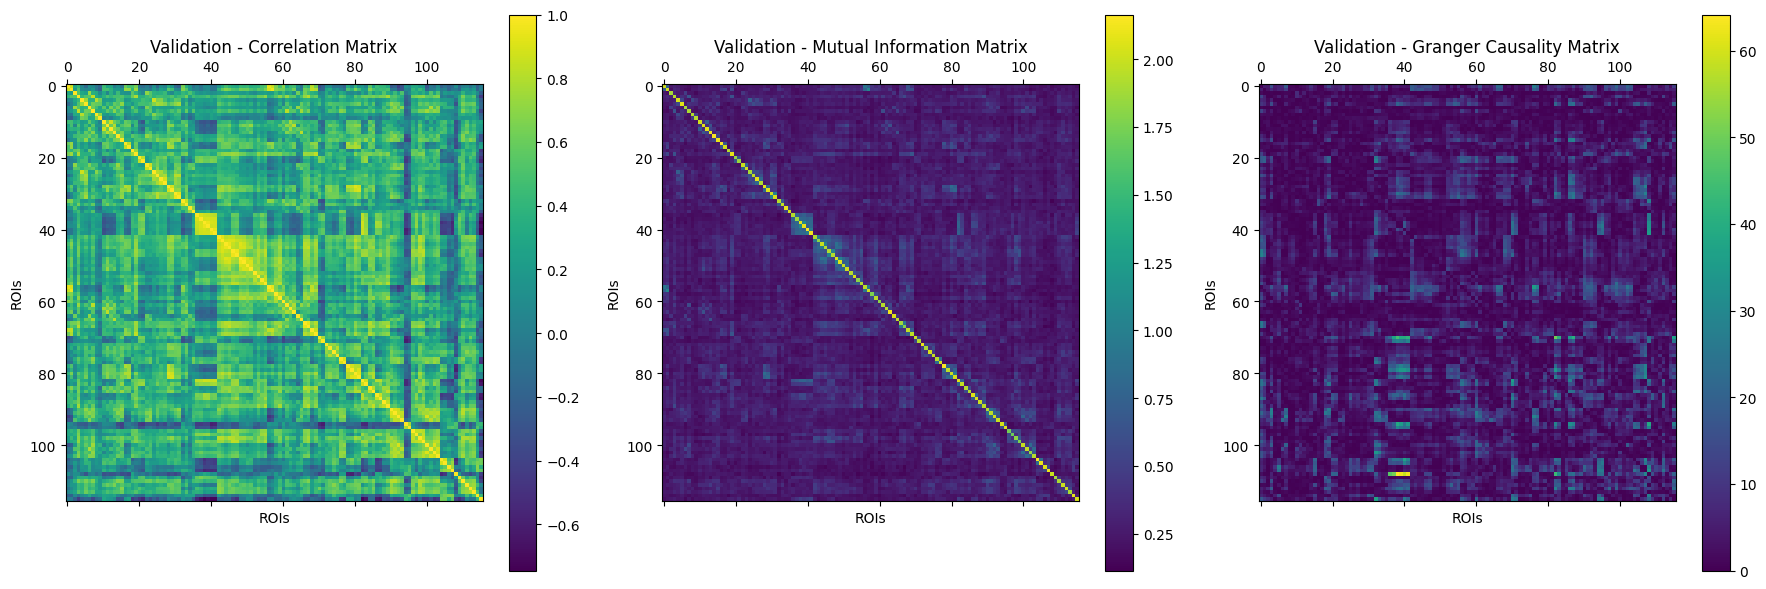

Plotting matrices for a random subject from Test dataset: /home/diego/Escritorio/azheimer/TensorData/CN_tensor_177_S_6335.pt


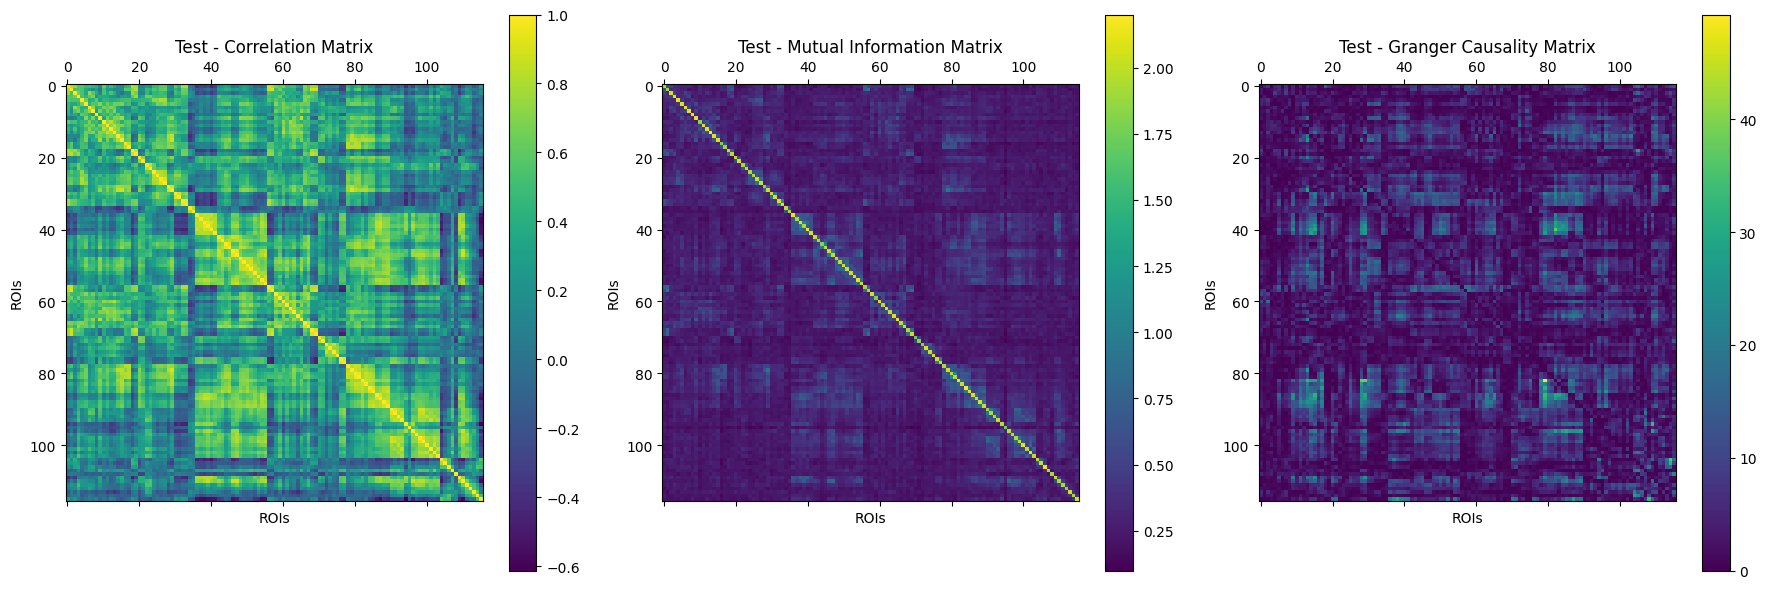

In [4]:
import random
import matplotlib.pyplot as plt

# Function to plot the three matrices for a given subject's tensor
def plot_matrices(tensor, title_prefix):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    matrix_titles = ['Correlation Matrix', 'Mutual Information Matrix', 'Granger Causality Matrix']

    # Loop through the three matrices
    for i in range(3):
        ax = axes[i]
        cax = ax.matshow(tensor[i], cmap='viridis')
        fig.colorbar(cax, ax=ax)
        ax.set_title(f'{title_prefix} - {matrix_titles[i]}')
        ax.set_xlabel('ROIs')
        ax.set_ylabel('ROIs')

    plt.tight_layout()
    plt.show()

# Choose a random subject from each dataset and plot their matrices
def plot_random_subject_from_dataset(dataset, dataset_name):
    random_subject = random.choice(dataset)
    print(f"Plotting matrices for a random subject from {dataset_name} dataset: {random_subject}")
    
    # Load the tensor for the randomly selected subject
    tensor = torch.load(random_subject)
    
    # Plot the matrices
    plot_matrices(tensor, dataset_name)

# Plot one random subject from train, validation, and test datasets
plot_random_subject_from_dataset(train_set, 'Train')
plot_random_subject_from_dataset(val_set, 'Validation')
plot_random_subject_from_dataset(test_set, 'Test')


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F


In [6]:
class ConvVAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(ConvVAE, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder Layers
        self.enc_conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, stride=2, padding=1)  # Output: (32, 58, 58)
        self.enc_conv2 = nn.Conv2d(32, 64, 4, 2, 1)  # Output: (64, 29, 29)
        self.enc_conv3 = nn.Conv2d(64, 128, 4, 2, 1)  # Output: (128, 14, 14)
        self.enc_conv4 = nn.Conv2d(128, 256, 4, 2, 1)  # Output: (256, 7, 7)
        
        # Compute the size after convolutional layers to flatten
        self.flatten_size = 256 * 7 * 7
        
        # Latent space
        self.fc_mu = nn.Linear(self.flatten_size, latent_dim)
        self.fc_logvar = nn.Linear(self.flatten_size, latent_dim)
        
        # Decoder Layers
        self.fc_decode = nn.Linear(latent_dim, self.flatten_size)
        self.dec_conv1 = nn.ConvTranspose2d(256, 128, 4, 2, 1)  # Output: (128, 14, 14)
        self.dec_conv2 = nn.ConvTranspose2d(128, 64, 4, 2, 1)   # Output: (64, 28, 28)
        self.dec_conv3 = nn.ConvTranspose2d(64, 32, 4, 2, 1)    # Output: (32, 56, 56)
        self.dec_conv4 = nn.ConvTranspose2d(32, 3, 4, 2, 1)     # Output: (3, 112, 112)
        
        # Since the input size is (3, 116, 116), adjust output size accordingly
        self.output_padding = nn.ConstantPad2d((2, 2, 2, 2), 0)  # Pad to (3, 116, 116)

    def encode(self, x):
        x = F.relu(self.enc_conv1(x))
        x = F.relu(self.enc_conv2(x))
        x = F.relu(self.enc_conv3(x))
        x = F.relu(self.enc_conv4(x))
        x = x.view(-1, self.flatten_size)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = F.relu(self.fc_decode(z))
        x = x.view(-1, 256, 7, 7)
        x = F.relu(self.dec_conv1(x))
        x = F.relu(self.dec_conv2(x))
        x = F.relu(self.dec_conv3(x))
        x = torch.sigmoid(self.dec_conv4(x))  # Use sigmoid for output activation
        x = self.output_padding(x)  # Adjust output size to (3, 116, 116)
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar


In [7]:
def loss_function(recon_x, x, mu, logvar):
    # Reconstruction loss (Binary Cross Entropy)
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    
    # KL Divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + KLD


In [8]:
from torch.utils.data import TensorDataset, DataLoader

# Create datasets
train_dataset = TensorDataset(train_data)
val_dataset = TensorDataset(val_data)
test_dataset = TensorDataset(test_data)

# Create data loaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [9]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize model
latent_dim = 20  # You can adjust the size of the latent space
model = ConvVAE(latent_dim=latent_dim).to(device)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


Using device: cuda


In [10]:
num_epochs = 250  # Adjust the number of epochs as needed

for epoch in range(1, num_epochs + 1):
    model.train()
    train_loss = 0
    for data in train_loader:
        x = data[0].to(device, dtype=torch.float)
        
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(x)
        loss = loss_function(recon_batch, x, mu, logvar)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader.dataset)
    print(f"Epoch {epoch}, Average Training Loss: {avg_train_loss:.4f}")
    
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data in val_loader:
            x = data[0].to(device, dtype=torch.float)
            recon_batch, mu, logvar = model(x)
            loss = loss_function(recon_batch, x, mu, logvar)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader.dataset)
    print(f"Epoch {epoch}, Average Validation Loss: {avg_val_loss:.4f}")


Epoch 1, Average Training Loss: 5217.8249
Epoch 1, Average Validation Loss: 5143.8861
Epoch 2, Average Training Loss: 4923.3001
Epoch 2, Average Validation Loss: 4346.3528
Epoch 3, Average Training Loss: 3595.1740
Epoch 3, Average Validation Loss: 2953.3906
Epoch 4, Average Training Loss: 2667.4599
Epoch 4, Average Validation Loss: 2362.4957
Epoch 5, Average Training Loss: 2225.9794
Epoch 5, Average Validation Loss: 2051.5977
Epoch 6, Average Training Loss: 1952.4478
Epoch 6, Average Validation Loss: 1787.0448
Epoch 7, Average Training Loss: 1718.9130
Epoch 7, Average Validation Loss: 1571.3516
Epoch 8, Average Training Loss: 1522.9039
Epoch 8, Average Validation Loss: 1413.2684
Epoch 9, Average Training Loss: 1399.6347
Epoch 9, Average Validation Loss: 1330.8232
Epoch 10, Average Training Loss: 1300.8389
Epoch 10, Average Validation Loss: 1215.5957
Epoch 11, Average Training Loss: 1188.9411
Epoch 11, Average Validation Loss: 1142.6187
Epoch 12, Average Training Loss: 1137.7303
Epoch 1

In [11]:
model.eval()
test_loss = 0
with torch.no_grad():
    for data in test_loader:
        x = data[0].to(device, dtype=torch.float)
        recon_batch, mu, logvar = model(x)
        loss = loss_function(recon_batch, x, mu, logvar)
        test_loss += loss.item()
avg_test_loss = test_loss / len(test_loader.dataset)
print(f"Average Test Loss: {avg_test_loss:.4f}")


Average Test Loss: 680.5318


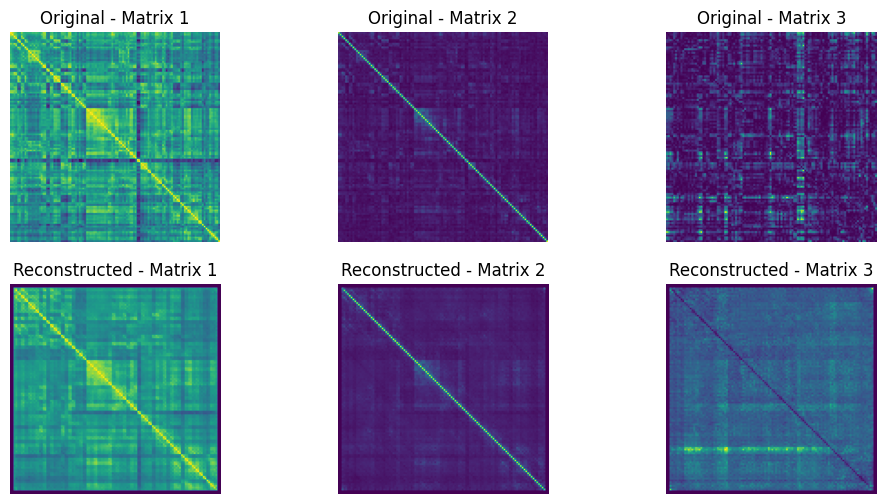

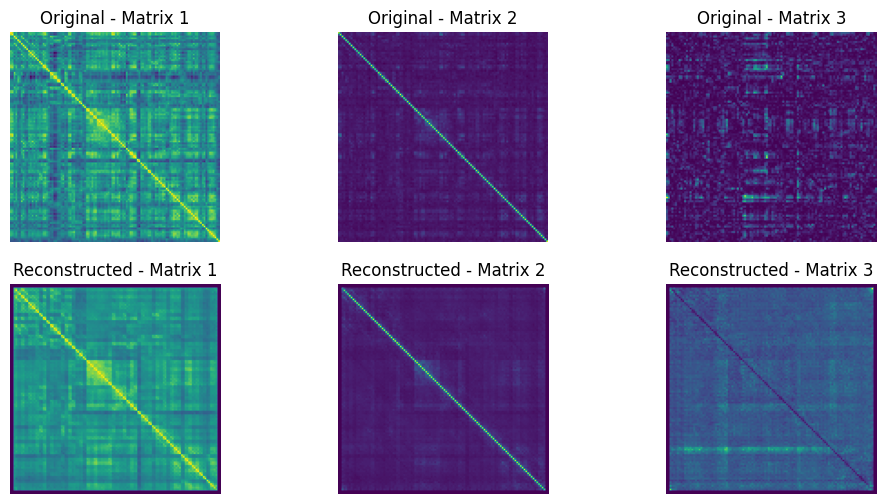

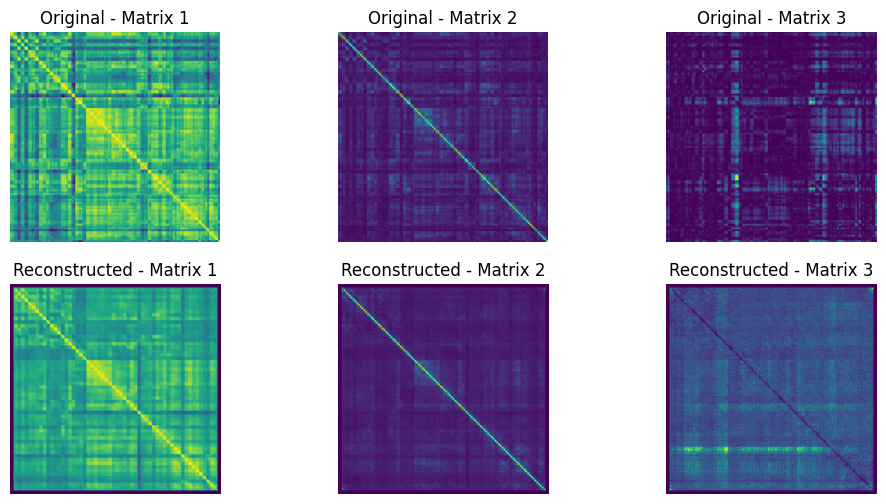

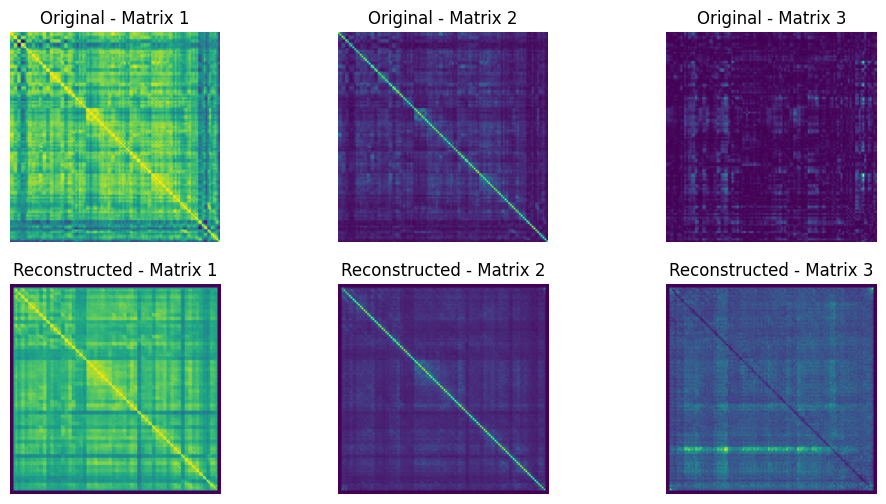

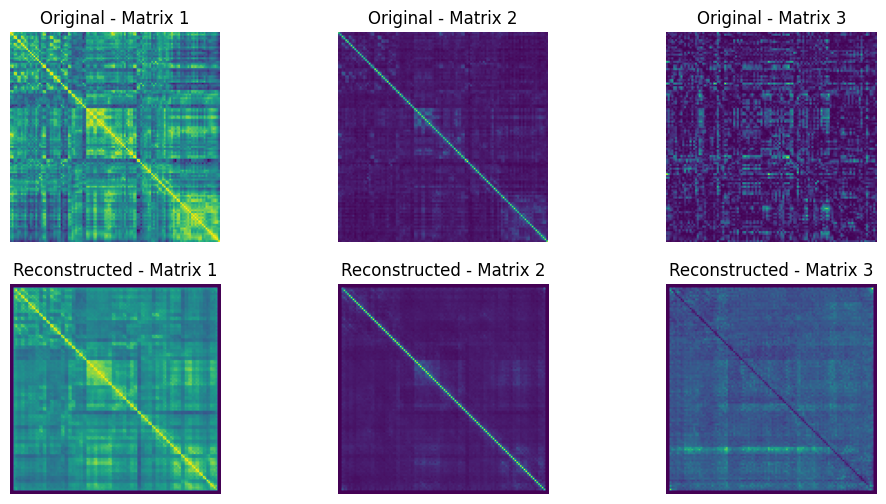

In [12]:
import matplotlib.pyplot as plt

# Function to display original and reconstructed images
def visualize_reconstruction(model, data_loader):
    model.eval()
    with torch.no_grad():
        data = next(iter(data_loader))
        x = data[0].to(device, dtype=torch.float)
        recon_x, _, _ = model(x)
        
        # Move tensors to CPU and convert to numpy
        x = x.cpu().numpy()
        recon_x = recon_x.cpu().numpy()
        
        n = min(x.shape[0], 5)  # Number of samples to display
        for i in range(n):
            fig, axes = plt.subplots(2, 3, figsize=(12, 6))
            for j in range(3):
                axes[0, j].imshow(x[i, j], cmap='viridis')
                axes[0, j].set_title(f'Original - Matrix {j+1}')
                axes[0, j].axis('off')
                axes[1, j].imshow(recon_x[i, j], cmap='viridis')
                axes[1, j].set_title(f'Reconstructed - Matrix {j+1}')
                axes[1, j].axis('off')
            plt.show()

# Visualize reconstructions on test data
visualize_reconstruction(model, test_loader)


In [13]:
# Save the trained model
model_save_path = os.path.join(project_dir, 'conv_vae_model.pth')
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


Model saved to /home/diego/Escritorio/azheimer/conv_vae_model.pth


In [14]:
# Load the model
model = ConvVAE(latent_dim=latent_dim).to(device)
model.load_state_dict(torch.load(model_save_path))
model.eval()


ConvVAE(
  (enc_conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (enc_conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (enc_conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (enc_conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (fc_mu): Linear(in_features=12544, out_features=20, bias=True)
  (fc_logvar): Linear(in_features=12544, out_features=20, bias=True)
  (fc_decode): Linear(in_features=20, out_features=12544, bias=True)
  (dec_conv1): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dec_conv2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dec_conv3): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dec_conv4): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (output_padding): ConstantPad2d(padding=(2, 2, 2, 2), value=0)
)